# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [58]:
import os, re, emoji
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [60]:
# Use this space for any additional import statements you need
from lexical_diversity import lex_div as ld
import matplotlib.pyplot as plt
from pandasql import sqldf
import itertools
from IPython.display import display

In [61]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

punct_pattern = re.compile("[" + re.escape("".join(tw_punct)) + "]")

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

emoji_blocks = list(emoji.EMOJI_DATA.keys())
for block in emoji_blocks:
    emoji_block_list = [char for char in list(block) if emoji.is_emoji(char)]
    if len(emoji_block_list):
        all_language_emojis.add(''.join(emoji_block_list))

# and now our functions
def descriptive_stats(tokens, most_common_tokens_number = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = len(set(tokens))/len(tokens)
    num_characters = len("".join(tokens))
        
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        most_common_tokens_list = Counter(tokens).most_common(most_common_tokens_number)
        print(f'\nMost Common Tokens are:\n{most_common_tokens_list}')

        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
        
    
def is_emoji(s):
    return(s in all_language_emojis)


def contains_emoji(s):
    s = str(s)
    emojis = [ch for ch in s if is_emoji(ch)]

    return(len(emojis) > 0)

def remove_stop(text_tokens) :
    clean_list = list()
    remove_words = stopwords.words("english") + ['️','',' ']
    tokens = [word.lower() for word in text_tokens]
    
    for i, word in enumerate(tokens):
        if not word in remove_words:
            clean_list.append(text_tokens[i])
    return clean_list

def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    return(text)


def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    collapse_whitespace = re.compile(r'\s+')
    whitespace_tokenized = [item for item in collapse_whitespace.split(text)]
    
    return whitespace_tokenized


def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [62]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = '/Users/nima/Downloads/'
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'MaherZains':'MaherZains_follower_data.txt',
                'SamiYusuf':'SamiYusuf_follower_data.txt'}

In [63]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['MaherZains'], sep="\t", quoting=3)

twitter_data['artist'] = "MaherZains"

In [64]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['SamiYusuf'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "SamiYusuf"

twitter_data = pd.concat([twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [151]:
# read in the lyrics here

lyrics_data = pd.DataFrame()

folders = os.listdir(data_location + lyrics_folder)
artists_names = [folder for folder in folders if folder[0] != "."]

def read_content(row, parent_fld):
    if row.file_name[0] == ".": return None
        
    with open(parent_fld + row.artist + '/' + row.file_name) as f:
        return f.read()
    
for artist in artists_names:
    songs = os.listdir(data_location + lyrics_folder + artist)
    df = pd.DataFrame(songs, columns=['file_name'])
    df['artist'] = artist
    df['lyrics'] = df.apply(read_content, parent_fld = data_location + lyrics_folder, axis=1)

    lyrics_data = pd.concat([lyrics_data, df], ignore_index=True)
    
lyrics_data.dropna(subset=['lyrics'], inplace=True)

lyrics_data

,file_name,artist,lyrics
0,samiyusuf_thecaveofhira.txt,sami_yusuf,<i>[Chorus]</i>\nHayya ‘ibad Allah\n(Come O se...
1,samiyusuf_yamustafa.txt,sami_yusuf,"Mustafa, Mustafa, Mustafa.\nYa Mustafa ya Must..."
3,samiyusuf_myonlywishinterlude.txt,sami_yusuf,"All your armies, all your fighters\nAll your t..."
4,samiyusuf_whoisthelovedone.txt,sami_yusuf,Who is the Loved One? Allah\nWho is Ar-Rahman?...
5,samiyusuf_foreverpalestine.txt,sami_yusuf,Mother don’t cry for me I am heading off to wa...
6,samiyusuf_meditation.txt,sami_yusuf,Assalatu wa as-salamu ‘alayk\n‘alayka ya Rasul...
7,samiyusuf_myummahintro.txt,sami_yusuf,Aynal ummah?\nAynal ummah?\n\nRabbana unsurna\...
8,samiyusuf_myummah.txt,sami_yusuf,"My ummah, my ummah\nHe will say\nRasulullah on..."
9,samiyusuf_motherarabic.txt,sami_yusuf,Blessed is your face\nBlessed is your name\nMy...
10,samiyusuf_dua.txt,sami_yusuf,Ne guzel yaratmissin nimetlerini\nbiz kullarin...


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove punctuation
* Split on whitespace
* Remove stopwords (optional)

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove punctuation other than emojis or hashtags
* Split on whitespace
* Remove stopwords

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [66]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 

In [67]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [68]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
127835,MaherZains,A Guest | Traveller | Husband | Father | Broth...,"[guest, traveller, husband, father, brother, f..."
179545,SamiYusuf,𝐌𝐞𝐝𝐢𝐚 𝐏𝐫𝐨𝐝𝐮𝐜𝐞𝐫 🎬 | 𝐈𝐓 𝐌𝐚𝐧𝐚𝐠𝐞𝐦𝐞𝐧𝐭 𝐄𝐧𝐠 💻 | 𝐈𝐧𝐬𝐭𝐫...,"[𝐌𝐞𝐝𝐢𝐚, 𝐏𝐫𝐨𝐝𝐮𝐜𝐞𝐫, 🎬, 𝐈𝐓, 𝐌𝐚𝐧𝐚𝐠𝐞𝐦𝐞𝐧𝐭, 𝐄𝐧𝐠, 💻, 𝐈..."
187103,SamiYusuf,"Graduated from the Faculty of Agriculture, Dep...","[graduated, faculty, agriculture, department, ..."
112280,MaherZains,♡♥♡,[♡♥♡]
43191,SamiYusuf,‏‏‏‏‏‏‏‏‏‏‏‏‏‏‏‏تعز عليا كرامتي و يرخص من أجله...,"[‏‏‏‏‏‏‏‏‏‏‏‏‏‏‏‏تعز, عليا, كرامتي, و, يرخص, م..."
7439,MaherZains,𝑻 𝑹 𝑨 𝑵 𝑸 𝑼 𝑰 𝑳 𝑰 𝑻 𝒀💙😍,"[𝑻, 𝑹, 𝑨, 𝑵, 𝑸, 𝑼, 𝑰, 𝑳, 𝑰, 𝑻, 𝒀💙😍]"
8306,MaherZains,Helwan University🎓,"[helwan, university🎓]"
10398,SamiYusuf,Yasoo 👸🏻💛|| اهلاويه ❤🦅|عسي ان تكرهوا شئ وهو خي...,"[yasoo, 👸🏻💛, اهلاويه, ❤🦅عسي, ان, تكرهوا, شئ, و..."
50632,SamiYusuf,al hamdoulilha♥,"[al, hamdoulilha♥]"
41893,SamiYusuf,"Sufi,Energy Healer, Ascension, Seeker of Truth...","[sufienergy, healer, ascension, seeker, truth,..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: It can be seen that if there is no space between a word and emoji, the two are combined into one token; this is also true about emoji and hashtags. every character has to be checked to see if it is an emoji or hashtag character, if so, there should be one space before and after it to improve the tokenization process.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [69]:
# your code here
def add_space_after_emoji(text):
    
    text_section = list()
    for i, char in enumerate(text):
        if emoji.is_emoji(char):
            text_section.append(' ' + text[i] + ' ')
        else:
            text_section.append(text[i])
        
        if (ZERO_WIDTH_JOINER:='\u200d') in text_section:
            text_section.remove(ZERO_WIDTH_JOINER)
         
    return ''.join(text_section)

def clean_string(text):
    if pd.isnull(text):
        return text
            
    remove_words = stopwords.words("english") + ['️','',' ']
    text = text.replace('|', ' ').replace('\n',' ')

    text = re.sub(punct_pattern, '', text)
    text = add_space_after_emoji(text)
    text_tokens = text.split(' ')
    text = [word.lower() for word in text_tokens]
    text = [word for word in text if not word in remove_words]
    return text

# remove the rows with no description/lyrics

lyrics_data['content_clean'] = lyrics_data.lyrics.apply(clean_string)

for artist in lyrics_data.artist.unique():
    content_clean = lyrics_data.loc[lyrics_data.artist == artist,'content_clean']
    content_all = list(itertools.chain(*content_clean.to_list()))
    print(f'\033[1mDescriptive Statistics for artist: {artist}\033[0m')
    stat = descriptive_stats(content_all, verbose=True)
    print('\n\n')
    

Descriptive Statistics for artist: sami_yusuf
There are 3177 tokens in the data.
There are 1259 unique tokens in the data.
There are 17519 characters in the data.
The lexical diversity is 0.396 in the data.

Most Common Tokens are:
[('ya', 188), ('allah', 130), ('muhammad', 87), ('lan', 56), ('allahu', 46)]



Descriptive Statistics for artist: maher_zain
There are 5210 tokens in the data.
There are 1180 unique tokens in the data.
There are 25490 characters in the data.
The lexical diversity is 0.226 in the data.

Most Common Tokens are:
[('allah', 246), ('oh', 97), ('ya', 93), ('upon', 79), ('love', 67)]





Q: what observations do you make about these data? 

A: The descriptive analysis on the lyrics shows that Maher Zain repeats same words more often in their songs which leads to smaller unique tokens while larger number of tokens in general.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [149]:
# your code here
from collections import Counter
def get_frequency_of_tokens_used(rows):    
    all_words = list(itertools.chain.from_iterable(rows.to_list()))
    word_counts = Counter(all_words)
    df_words =  pd.DataFrame.from_dict(word_counts, orient='index', columns=['count']).reset_index()
    df_words.rename(columns={'index': 'word'}, inplace=True)
    df_words.sort_values(by=['count'], ascending=False,  inplace=True) 
    return df_words

df_conc = pd.DataFrame()

def check_if_passes_cut_off(row, cut_off_value = 5):
    met_target = list()
    for col_name, value in row.items():
        if pd.isnull(value):
            return 'no'
        
        if 'corpus' in col_name:
            if value < cut_off_value:
                met_target.append('below')
    
    return 'no' if 'below' in met_target else 'yes'


corpus_token_count = dict()
df_conc = pd.DataFrame()

for artist in lyrics_data.artist.unique():
    content_clean = lyrics_data.loc[lyrics_data.artist == artist,'content_clean']
    content_all = list(itertools.chain(*content_clean.to_list()))
    tokens_count = Counter(content_all)
    artist_words_used = pd.DataFrame.from_dict(tokens_count, orient='index', columns=['count'])
    artist_words_used['word'] = artist_words_used.index
    artist_words_used.reset_index(inplace=True, drop=True)
    artist_words_used.sort_values(by=['count'], ascending=False,  inplace=True) 

    corpus_token_count[artist] = artist_words_used['count'].sum()
    
    for i, row in artist_words_used.iterrows():
        df_conc.loc[row.word,'corpus_'+ artist] = row['count']
        df_conc.loc[row.word,'concentration_'+ artist] = row['count'] / corpus_token_count[artist]
        
df_conc['passes_cut_off'] = df_conc.apply(check_if_passes_cut_off, axis=1)

concentration_cols = [col for col in df_conc.columns if 'concentration' in col]
corp_format_dict = {col:'{:.0f}' for col in df_conc.columns if 'corpus' in col}

df_conc['ratio'] = df_conc[concentration_cols[0]] / df_conc[concentration_cols[1]]

df_show = df_conc[df_conc.passes_cut_off == 'yes'].nlargest(columns=['ratio'], n=10)

df_show.style.format(corp_format_dict)


,corpus_sami_yusuf,concentration_sami_yusuf,corpus_maher_zain,concentration_maher_zain,passes_cut_off,ratio
muhammad,87,0.027384,15,0.002879,yes,9.511489
allahu,46,0.014479,22,0.004223,yes,3.428907
ya,188,0.059175,93,0.017850,yes,3.315091
forgive,12,0.003777,6,0.001152,yes,3.279824
blessed,8,0.002518,5,0.000960,yes,2.623859
habibi,11,0.003462,7,0.001344,yes,2.577004
lord,17,0.005351,12,0.002303,yes,2.323208
send,14,0.004407,10,0.001919,yes,2.295877
show,7,0.002203,5,0.000960,yes,2.295877
night,7,0.002203,5,0.000960,yes,2.295877


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: Since both of artists are muslims and advocator of god's forgiveness, words such as Allah (god) and muhammad (the holy prophet) and forgive are shown as expected.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


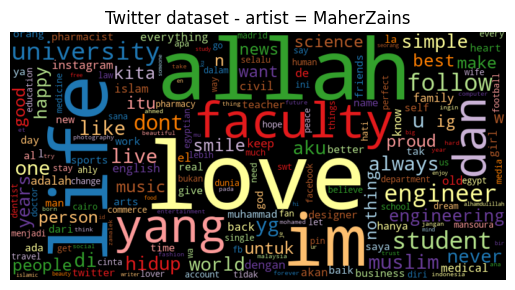

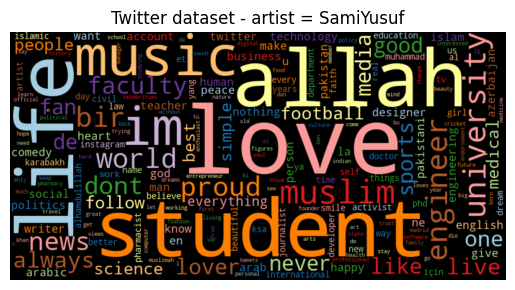

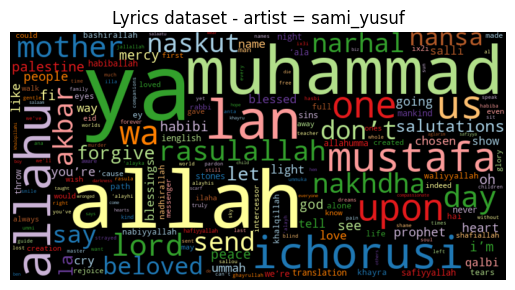

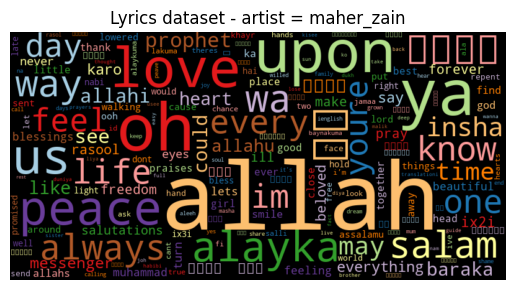

In [ ]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, 
                                     orient='index', 
                                     columns=['freq'])
    
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

def get_english_words_only(row):
    reg = re.compile(r'[a-z]')
    return [block for block in row if reg.match(block)]

# since the word cloud only displays english words, arabic 
# words comes out as ▯, none english words are dropped.

twitter_data['description_english_words'] = \
                twitter_data.description_clean.apply(get_english_words_only)


datasets = {'Twitter': twitter_data, 'Lyrics': lyrics_data}
column_to_use = {'Twitter': 'description_english_words', 'Lyrics': 'content_clean'}

for dataset, df in datasets.items():
    for artist in df.artist.unique():
        artist_df = df[df.artist == artist]
        word_dict = count_words(artist_df, column_to_use[dataset]).to_dict()['freq']
        wordcloud(word_dict, 
                  title = f'{dataset} dataset - artist = {artist}', 
                  stopwords='drop')


Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: The word Allah is shown in all 4 datasets. Since most of the people that are following the artists are yound, the word student is shown (they have student as hashtag in their description). 